# Extrinsic Camera Calibration 

Sensor calibration is one of the most important aspects of building a robot. Different sensors have different calibration procedures. Typically one can distinguish between intrinsic and extrinsic calibration. Intrinsic camera calibration tries to estimate the camera matrix $K$ (and potentially other camera-specific parameters like distortion coefficients). You can learn more about it in this [lecture by Cyril Stachniss](https://www.youtube.com/watch?v=Ou9Uj75DJX0), and this [OpenCV python tutorial](https://docs.opencv.org/4.5.2/dc/dbb/tutorial_py_calibration.html). For this chapter, we will be focusing on extrinsic camera calibration. 

Refer back to the [From Pixels to meters chapter](../LaneDetection/InversePerspectiveMapping.ipynb). If you did the exercises of that chapter, you may recall that to convert the lane line pixels detected by the neural network to meters, you needed the camera height $h$ and the rotation matrix $\mathbf{R_{cr}}$, which describes how the camera is oriented with respect to the road reference frame. 

```{admonition} Reminder: Road reference frame
:class: tip
The "road reference frame" was defined in [the chapter on camera basics](../LaneDetection/CameraBasics.ipynb), and it is attached to the vehicle.  The $Z$ direction in the road reference frame is always identical to the vehicle's forwards axis and the $Y$ axis is identical to the vehicle's "downwards axis". The name "road reference frame" could be a bit misleading. The only reason we used the word "road" for this reference frame, is because the $Z-X$-plane in this reference frame is identical to the road plane, which we approximate as flat.
```

$\mathbf{R_{cr}}$ was very easy to obtain through the CARLA simulator. But this is not that easy in real life. When you mount the camera to your vehicle, you can try to make it perfectly straight, which would correspond to $\mathbf{R_{cr}} = \mathbf{1}$, but you will always make a small mistake, which makes calibration necessary. The orientation with respect to the road could also change dynamically, which makes calibration challenging: 
The road is not always flat. It can be banked, elevated or just uneven and therefore, the orientation of the car and the camera keeps changing with respect to the flat road frame. The orientation of the car and the camera may also change with respect to the road if the car breaks are hit hard or due to the car suspension. 

Proper extrinsic calibration is essential for good vehicle control. The following plot shows two simulations in which the camera was mounted with a yaw of 4 degrees and a pitch of -4 degrees. In the first simulation, these yaw and pitch values were passed correctly to the `CameraGeometry` object, which was implemented in the chapter on Lane Detection. Hence, in this first simulation the calibraton was *perfect*. In the second simulation, default values of zero degrees were incorrectly assumed for both pitch and yaw. Hence, there was no calibration at all. 

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/usr/local/opt/python@3.10/bin/python3.10
3.10.8 (main, Oct 13 2022, 10:19:13) [Clang 12.0.0 (clang-1200.0.32.29)]
sys.version_info(major=3, minor=10, micro=8, releaselevel='final', serial=0)


In [1]:
import numpy as np
cte_no_calib = np.load("../../data/cte_yaw_4_no_calib.npy")
cte_with_calib = np.load("../../data/cte_yaw_4_with_calib.npy")
cte_perfect_calib = np.load("../../data/cte_yaw_4_perfect_calib.npy")

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/var/folders/7x/wrq6mp817f56hpd7kgpmpws00000gn/T/ipykernel_17585/1246088218.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


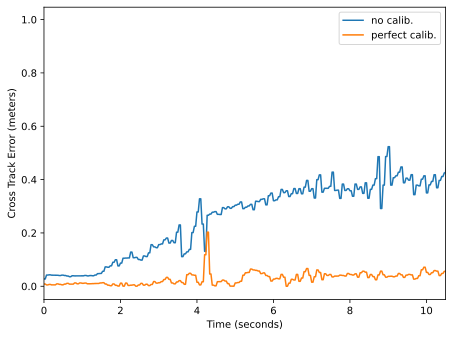

In [2]:
get_time = lambda x: np.array(range(len(x)))/30
plt.plot(get_time(cte_no_calib), cte_no_calib, label="no calib.")
plt.plot(get_time(cte_perfect_calib), cte_perfect_calib, label="perfect calib.")
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("Cross Track Error (meters)")
plt.xlim(0,10.5)
plt.tight_layout()

As you can see in the plot, having no calibration at all makes the vehicle leave the center of the lane until it has a constant offset of around 40 cm from the middle of the lane. Why does this happen? The wrong yaw and pitch values lead to the computation of a wrong reference path, which is then passed to the controller.  In case of *perfect calibration* the results looks different. Here, the vehicle stays in the middle of the lane within an error of around 5 cm (except for one small disturbance at around 4 seconds which is due to a bad detection of the neural network).

But as already mentioned, in the real world we do not know the exact mounting of the camera. So what we will need to do is to estimate the mounting. In this chapter you will learn how to estimate the pitch and yaw angle. The method you will learn leads to simulation results denoted as "VP calib." in the plot below:

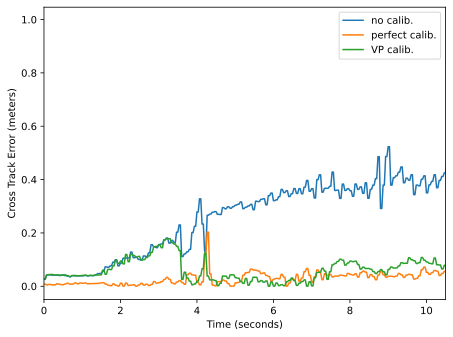

In [3]:
get_time = lambda x: np.array(range(len(x)))/30
plt.plot(get_time(cte_no_calib), cte_no_calib, label="no calib.")
plt.plot(get_time(cte_perfect_calib), cte_perfect_calib, label="perfect calib.")
plt.plot(get_time(cte_with_calib), cte_with_calib, label="VP calib.")
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("Cross Track Error (meters)")
plt.xlim(0,10.5)
plt.tight_layout()

First, the vehicle leaves the middle of the lane, but then it has gathered enough data to estimate yaw and pitch angles. Consequently, it can recover and stay close to the middle of the lane. Let's learn how this "VP calib." method works!

## Vanishing Point Method

Our aim is to find the rotation matrix $\mathbf{R_{cr}}$, which describes how the camera is rotated

We know that the rail tracks or the lane lines are mostly parallel, however, if we take an image of the track or road from a camera, we would observe that the track lines or the lanes are not parallel in the image. The point where these lines intersect in an image is known as the vanishing point.

```{figure} images/vanishing_point.png
---
width: 50%
name: vanishing_point_carla
---
```

```{figure} images/Vanishing_point.svg
---
width: 50%
name: vanishing_point
---
Image Source [wikipedia](https://en.wikipedia.org/wiki/Vanishing_point)
```

We know that in the world coordinate system, these parallel lines won't ever intersect. So we say that the vanishing point is at infinity. Assuming that the car's forwards direction is aligned with the lane lines, we can say that the lane lines intersect at $Z=\infty$, where $(X,Y,Z)$ are coordinates of a point in the road reference frame (reminder: the road reference frame is attached to the vehicle, and $Z$ is the vehicle's forwards axis). 
```{admonition} Important assumption!
:class: warning
The assumption we just made is very important: The vehicle is aligned with the lane, and the lane is straight. Then, the intersection of the lane lines in the image (vanishing point), will give us information about the camera mounting, i.e., the orientation of the camera with respect to vehicle. Otherwise it would only tell us something about the orientation of the vehicle with respect to the lane lines.
```

Now recall the camera projection equation

$$
    \lambda \begin{pmatrix} u \\ v\\ 1 \end{pmatrix} = \mathbf{K} \begin{pmatrix} \mathbf{R_{cr}} | \mathbf{t} \end{pmatrix}  \begin{pmatrix} X \\ Y \\ Z \\ 1 \end{pmatrix}
$$

Since this is an equation in homogeneous coordinates, we can multiply both sides by $1/Z$ and absorb this number in $\lambda$ on the left hand side:

$$
    \lambda \begin{pmatrix} u \\ v\\ 1 \end{pmatrix} = \mathbf{K} \begin{pmatrix} \mathbf{R_{cr}} | \mathbf{t} \end{pmatrix}  \begin{pmatrix} X/Z \\ Y/Z \\ 1 \\ 1/Z \end{pmatrix}
$$

If we let $Z$ go to infinity, we obtain the coordinates $(u,v)$ of the vanishing point in image space:

$$
    \lambda \begin{pmatrix} u \\ v\\ 1 \end{pmatrix} = \mathbf{K} \begin{pmatrix} \mathbf{R_{cr}} | \mathbf{t} \end{pmatrix} \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0 \end{pmatrix}
$$

We define $\mathbf{p_{\infty}} = (u,v,1)^T$ for the vanishing point and we write down the transformation matrix components to obtain

$$
    \lambda \mathbf{p_{\infty}} = \mathbf{K} \begin{pmatrix} R_{xx}  R_{xy}  R_{xz}  t_x \\ R_{yx}  R_{yy}  R_{yz}  t_y \\ R_{zx}  R_{zy}  R_{zz}  t_z \end{pmatrix} \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0 \end{pmatrix}
$$



Now, multiplying the transformation matrix with $(0,0,1,0)^T$ will eliminate the 1st, 2nd and 4th columnn, leaving us with only the 3rd column whose values are $R_{xz}$, $R_{yz}$  and $R_{zz}$. Let us denote this column by $\mathbf{r_{3}}$. Then

$$
    \lambda \mathbf{p_{\infty}} = \mathbf{K} \mathbf{r_{3}}
$$


Columns of a rotation matrix are always vectors with length 1 (unit vectors), so $\|\mathbf{r_{3}}\|=1$. Thus, $\lambda$ equals $\frac{1} {\| \mathbf{K}^{-1} \mathbf{p_{\infty}}\| }$ and we obtain

$$
    \mathbf{r_{3}} = \frac{\mathbf{K}^{-1} \mathbf{p_{\infty}}} {\| \mathbf{K}^{-1} \mathbf{p_{\infty}}\| }
$$ (label_r3_equals_invKpinf)



The idea of the vanishing point method for extrinsic calibration is the following: We determine the vanishing point $(u,v)$ in the image as the point were the lanes lines intersect. This yields $\mathbf{p_{\infty}} = (u,v,1)^T$. Since we know the intrinsic matrix $\mathbf{K}$, we can compute $\mathbf{r_3}$ using the formula above (Eq. {eq}`label_r3_equals_invKpinf`). Of course $\mathbf{r_3}$ is only one of the three columns of the rotation matrix, but as we will show later, $\mathbf{r_3}$ contains enough information to determine the yaw and pitch angle of the rotation. If we then assume that the roll angle is zero (of course an approximation), we can compute the whole rotation matrix. 

With this vanishing point method, we are able to only recover **yaw** and **pitch** of the camera. It makes intuitive sense that the vanishing point method is not able to recover **roll** and **translation** because the vanishing point is not affected by these two! Imagine looking at a star. The star's position is only going to change if you change the yaw and pitch of your head and is not affected by roll and translation. 

```{figure} images/car_rpy.svg
---
width: 60%
name: coordinate_system
---
```

Let's understand this by an example from CARLA. First, let us inspect of changing the roll angle:


````{tabbed} roll = -20°
```{figure} images/images_vp/p-0-y-0-r-20.png
---
width: 90%
name: roll_minus_20
---
```
````

````{tabbed} roll = 0°
```{figure} images/images_vp/p-0-y-0.png
---
width: 90%
name: roll_0 
---
```
````

````{tabbed} roll = 20°
```{figure} images/images_vp/p-0-y-0-r--20.png
---
width: 90%
name: roll_20
---
```
````

You can see that the vanishing point didn't change. Similarly, let's see if this also holds true for translation:



````{tabbed} translation = -2 m
```{figure} images/images_vp/trans--2.png
---
width: 90%
name: translation_minus_2
---
```
````

````{tabbed} translation = 0 m
```{figure} images/images_vp/p-0-y-0.png
---
width: 90%
name: translation_0
---
```
````

````{tabbed} translation = 2 m
```{figure} images/images_vp/trans-2.png
---
width: 90%
name: translation_2
---
```
````

You can see that the vanishing point lies at the same position for all the above images. This shows that roll and translation won't affect the vanishing point.


Now let's see the effect of changing pitch 


````{tabbed} pitch = -5°
```{figure} images/images_vp/p--5-y-0.png
---
width: 90%
name: pitch_minus_5
---
```
````

````{tabbed} pitch = 0°
```{figure} images/images_vp/p-0-y-0.png
---
width: 90%
name: pitch_0
---
```
````

````{tabbed} pitch = 5°
```{figure} images/images_vp/p-5-y-0.png
---
width: 90%
name: pitch_5
---
```


and yaw:



````{tabbed} yaw = -5°
```{figure} images/images_vp/p-0-y--10.png
---
width: 90%
name: yaw_minus_5
---
```
````

````{tabbed} yaw = 0°
```{figure} images/images_vp/p-0-y-0.png
---
width: 90%
name: yaw_0
---
```
````

````{tabbed} yaw = 5°
```{figure} images/images_vp/p-0-y-10.png
---
width: 90%
name: yaw_5
---
```


As you can see, the vanishing point shifted in this case. Next let us explore how we can determine yaw and pitch from $\mathbf{r_3}$

## Deriving yaw and pitch from the vanishing point

We discussed the rotation matrix in detail in the section [Basis of Image Formation](../LaneDetection/CameraBasics.ipynb) within the Lane Detection chapter. The rotation matrix parametrized by yaw, pitch and roll is given by 

$$
    {R} = R_{yaw}R_{pitch}R_{roll}
$$

$$
   {R} = \begin{pmatrix} \cos(\gamma)\cos(\beta) + \sin(\alpha)\sin(\gamma)\sin(\beta)  & \cos(\gamma)\sin(\alpha)\sin(\beta) -\cos(\beta)\sin(\gamma) & -\cos(\alpha)\sin(\beta)  \\
                          \cos(\alpha)\sin(\gamma) & \cos(\alpha)\cos(\gamma) & \sin(\alpha)  \\
                          \cos(\gamma)\sin(\beta) -\cos(\beta)\sin(\alpha)\sin(\gamma)  & -\cos(\gamma)\cos(\beta)\sin(\alpha) -\sin(\gamma)\sin(\beta)  & \cos(\alpha)\cos(\beta) \\
                            \end{pmatrix} 
$$

$\alpha, \beta, \gamma$ are the pitch, yaw, and roll angles respectively.

The third column of this rotation matrix is

$$
    \begin{pmatrix}  -\cos(\alpha)\sin(\beta) \\
                            \sin(\alpha) \\
                            \cos(\alpha)\cos(\beta) \\
                            \end{pmatrix}  = \mathbf{r_{3}} = \begin{pmatrix} R_{xz} \\ R_{yz} \\ R_{zz} \end{pmatrix}
$$ (label_r3_RRR)


If we determine the vanishing point $(u,v)$ in the image, we know $\mathbf{p_\infty} = (u,v,1)^T$ and hence we can compute the value of $\mathbf{r_3}= (R_{xz}, R_{yz}, R_{zz})^T$ from Eq. {eq}`label_r3_equals_invKpinf`:  $\mathbf{r_{3}} = \mathbf{K}^{-1} \mathbf{p_{\infty}} / \| \mathbf{K}^{-1} \mathbf{p_{\infty}}\| $.

Solving Eq. {eq}`label_r3_RRR` for $\alpha$ and $\beta$ we get:

$$
    \alpha = \sin^{-1}{R_{yz}}
$$ (label_eq_alpha)

$$
    \beta = -\tan^{-1}\frac{R_{xz}}{{R_{zz}}}
$$ (label_eq_beta)



We have thus derived pitch and yaw from the vanishing point! Next, let us see how we can determine the vanishing point from an image using our lane detector.

## Vanishing point from lane lines

In [4]:
import cv2
import numpy as np
import copy
%matplotlib inline
import matplotlib.pyplot as plt

ImportError: dlopen(/Users/mihail/Documents/GitHub/calib_challenge/.venv/lib/python3.10/site-packages/cv2/cv2.abi3.so, 2): Symbol not found: _VTRegisterSupplementalVideoDecoderIfAvailable
  Referenced from: /Users/mihail/Documents/GitHub/calib_challenge/.venv/lib/python3.10/site-packages/cv2/.dylibs/libavcodec.59.37.100.dylib (which was built for Mac OS X 11.0)
  Expected in: /System/Library/Frameworks/VideoToolbox.framework/Versions/A/VideoToolbox
 in /Users/mihail/Documents/GitHub/calib_challenge/.venv/lib/python3.10/site-packages/cv2/.dylibs/libavcodec.59.37.100.dylib

In [6]:
img = cv2.imread('images/test.png')[:, :, (2, 1, 0)]
plt.imshow(img);

NameError: name 'cv2' is not defined

This image was collected from CARLA having a pitch of -5 degrees and yaw of -2 degrees. We aim to obtain these values of pitch and yaw just from the image. For that we will be using our lane detector network trained previously to find the left and right lane boundaries. The intersection of them will lead to the vanishing point. 

In [5]:
import sys, copy
sys.path.append('../../code')
from solutions.lane_detection.lane_detector import LaneDetector

model_path = "../../code/solutions/lane_detection/fastai_model.pth"
ld = LaneDetector(model_path=model_path)

ImportError: dlopen(/Users/mihail/Documents/GitHub/calib_challenge/.venv/lib/python3.10/site-packages/cv2/cv2.abi3.so, 2): Symbol not found: _VTRegisterSupplementalVideoDecoderIfAvailable
  Referenced from: /Users/mihail/Documents/GitHub/calib_challenge/.venv/lib/python3.10/site-packages/cv2/.dylibs/libavcodec.59.37.100.dylib (which was built for Mac OS X 11.0)
  Expected in: /System/Library/Frameworks/VideoToolbox.framework/Versions/A/VideoToolbox
 in /Users/mihail/Documents/GitHub/calib_challenge/.venv/lib/python3.10/site-packages/cv2/.dylibs/libavcodec.59.37.100.dylib

First let us run our neural network to compute for each pixel the probability whether it is background, left boundary or right boundary:

In [ ]:
background_prob, left_prob, right_prob = ld.detect(img)

All pixels where `left_prob` is large (let's say larger than `0.5`), can be considered as pixels of the left boundary. Let us make all those pixels blue to get a nice visualization. Similarly we make the right boundary pixels red:

In [ ]:
img_with_detection = copy.copy(img)
img_with_detection[left_prob > 0.5, :] = [0,0,255] # blue
img_with_detection[right_prob > 0.5, :] = [255,0,0] # red
plt.imshow(img_with_detection)
plt.xlabel('$u$'); plt.ylabel('$v$');

To determine the intersection of the blue and red line, we describe each of them by an equation $v(u)=m u+c$, where $u$ and $v$ are the pixel coordinates (see the axes labels in the image above). Then, it is a high school math problem to find the intersection point.

Getting the line equation $v(u)=m u+c$ for the left lane line from our `prob_left` matrix is actually just two lines of python code:

In [ ]:
# get a list of all u and v values for which left_prob[v,u] > 0.5
v_list, u_list = np.nonzero(left_prob >0.5)
# Fit a polynomial of degree 1 (which is a line) to the list of pixels
poly_left = np.poly1d(np.polyfit(u_list, v_list, deg=1))

Let's add two more lines of code for the right boundary

In [ ]:
v_list, u_list = np.nonzero(right_prob >0.5)
poly_right = np.poly1d(np.polyfit(u_list, v_list, deg=1))

And finally some code to visualize our lines

In [ ]:
def show_img_and_lines():
    plt.imshow(img)
    u = np.arange(0, 1024)
    v_left = poly_left(u)
    v_right = poly_right(u)
    plt.plot(u, v_left, color="b")
    plt.plot(u, v_right, color="r")
    plt.xlim(0, 1024); plt.ylim(512, 0)
    plt.xlabel('$u$'); plt.ylabel('$v$');
show_img_and_lines()

In the exercises you will write code that determines the coordinates of the intersection points of two lines. We can import it here to determine the vanishing point:

In [ ]:
from solutions.camera_calibration.calibrated_lane_detector import get_intersection
u_i, v_i = get_intersection(poly_left, poly_right)
show_img_and_lines()
plt.scatter([u_i], [v_i], marker="o", s=100, color="y", zorder=10);

Finally, we can find pitch and yaw of the camera form the vanishing point using Eqs. {eq}`label_r3_equals_invKpinf`, {eq}`label_eq_alpha`, {eq}`label_eq_beta`. Again you will write some code for this in the exercises.

In [ ]:
from solutions.camera_calibration.calibrated_lane_detector import get_py_from_vp
pitch, yaw = get_py_from_vp(u_i, v_i, ld.cg.intrinsic_matrix)

print(f'yaw degrees:   %.2f' % np.rad2deg(yaw))
print(f'pitch degrees: %.2f' % np.rad2deg(pitch))

This is very close to the correct values of -2 and -5! You can expect small errors in yaw and pitch because small errors in lane detection can lead to large errors for the vanishing point. Also the car will not always be perfectly aligned with the lane lines as it was in our example image. Therefore, the readings are mostly taken for a period of time from a video stream and then averaged.

This is why several automated driving systems like Tesla's autopilot or comma ai's openpilot require you to drive straight for a while to calibrate the cameras before you can engage the software to drive the car.

For the exercise, you will write a `CalibratedLaneDetector` class which inherits from the `LaneDetector` class. In each cycle it determines the vanishing points and uses that to estimate yaw and pitch. It stores this information to perform an averaging over time. Additionally, the `CalibratedLaneDetector` makes sure not to use images for averaging when the lane lines are curved, since the vanishing point should only be computed from straight lines. 

## Exercise

We provide you with a video. Your task is to use the lane detection network to calibrate the camera and output the yaw and pitch values. The video can be found in the `data` folder and is named `calibration_video.mp4`.

To start working on the exercises, open `code/tests/camera_calibration/calibrated_lane_detector.ipynb` and follow the instructions in that notebook.

If you completed the tasks from that notebook, you can optionally check your code with a CARLA simulation. Go to the parent folder of the `code` folder and run 

```bash
python -m code.tests.camera_calibration.carla_sim --help
```

to see instructions on how to run the simulation. 